# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import pickle
import requests

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/data.csv') 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [2]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Look at some basic statistics for numerical variables.

In [3]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)

In [4]:
df['Credit_History'].sum()

475.0

There are 475 applicants with a credit history out of 614

2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?

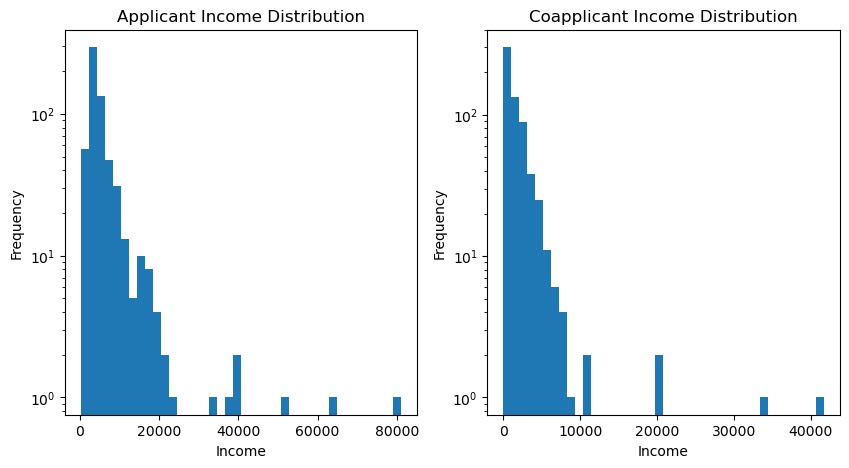

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].hist(df['ApplicantIncome'], bins=40)
ax[0].set_yscale('log')
ax[0].set_title('Applicant Income Distribution')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Income')

ax[1].hist(df['CoapplicantIncome'], bins=40)
ax[1].set_yscale('log')
ax[1].set_title('Coapplicant Income Distribution')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Income')

plt.show()

Applicant income is quite right skewed, which aligns with expectations for people wanting a loan. Interestingly, coapplicant income is similarly skewed but consistently lower. This may be because applicants strategize to have the main applicant be the one with higher income.

3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.

The mean is often higher than the median, especially with financial features like income. This is further evidence of a right skew. The one exception is Loan Amount Term, where the mean is slightly lower than the median of 365. This could be almost normal or a left skew.

Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [6]:
cat_cols = [
    'Gender',
    'Married',
    'Dependents',
    'Education',
    'Self_Employed',
    'Property_Area',
    'Loan_Status'
]
unique_count = []
for col in cat_cols:
    unique_count.append(len(df[col].unique()))
unique_count_df = pd.DataFrame(unique_count, index=cat_cols, columns=['Unique_Count'])
unique_count_df


,Unique_Count
Gender,3
Married,3
Dependents,5
Education,2
Self_Employed,3
Property_Area,3
Loan_Status,2


Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

In [7]:
for col in cat_cols:
    print(df[col].value_counts())

Gender
Male      489
Female    112
Name: count, dtype: int64
Married
Yes    398
No     213
Name: count, dtype: int64
Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64
Self_Employed
No     500
Yes     82
Name: count, dtype: int64
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64
Loan_Status
Y    422
N    192
Name: count, dtype: int64


### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



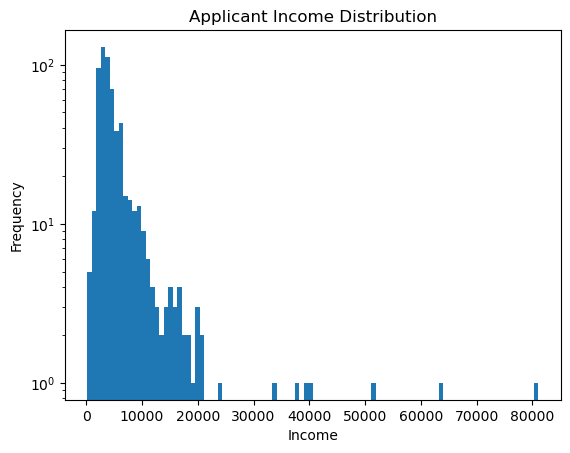

In [8]:
plt.hist(df['ApplicantIncome'], bins=100)
plt.yscale('log')
plt.title('Applicant Income Distribution')
plt.ylabel('Frequency')
plt.xlabel('Income')
plt.show()


Look at box plots to understand the distributions. 

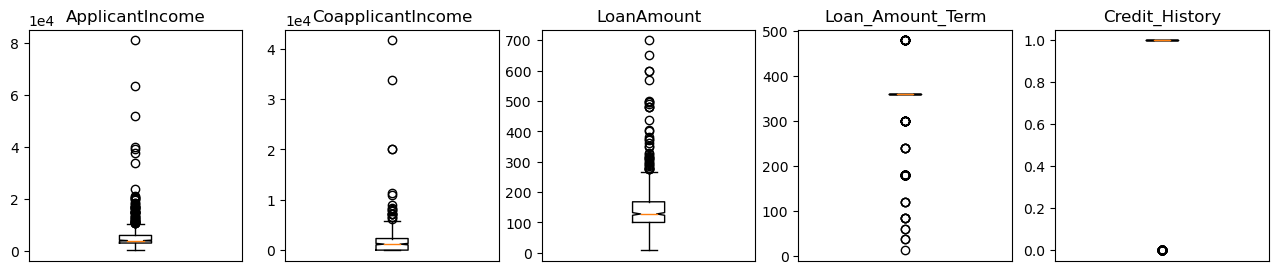

In [9]:
num_cols = [
    'ApplicantIncome',
    'CoapplicantIncome',
    'LoanAmount',
    'Loan_Amount_Term',
    'Credit_History'
]

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 3))

for i in range(5):
    col = num_cols[i]
    temp = df[col].dropna()
    ax[i].boxplot(temp, notch=True)
    ax[i].set_title(col)
    ax[i].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.show()

Look at the distribution of income segregated  by `Education`

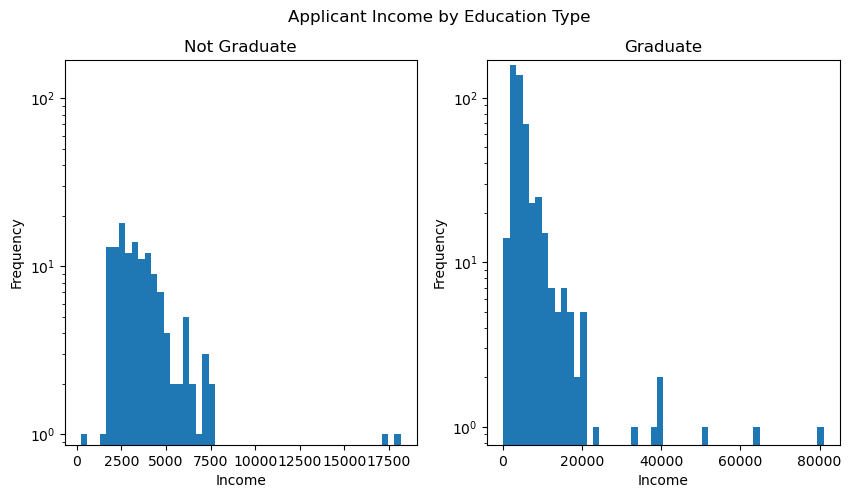

In [10]:
edu_vals = [
    'Not Graduate',
    'Graduate'
]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

fig.suptitle('Applicant Income by Education Type')

for i in range(2):
    edu = edu_vals[i]
    ax[i].hist(df[df['Education'] == edu]['ApplicantIncome'], bins=50)
    ax[i].set_title(edu)

    ax[i].set_yscale('log')
    ax[i].set_ylim(0, 170)
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Income')

Look at the histogram and boxplot of LoanAmount

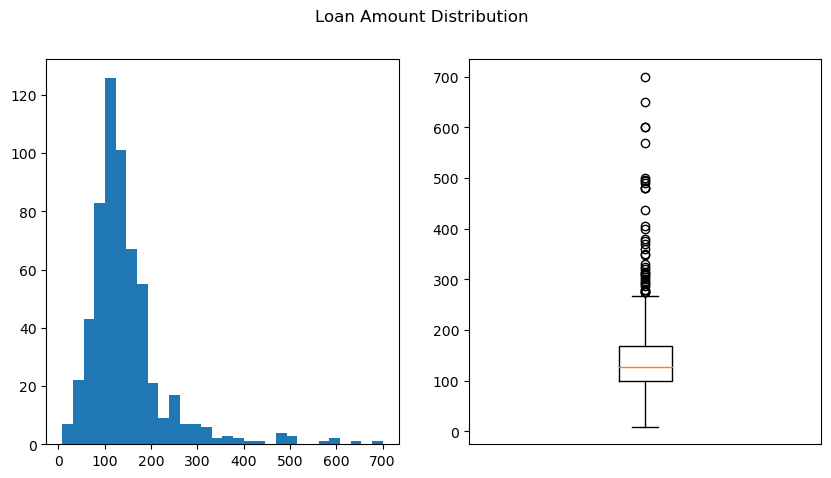

In [11]:
loans_notna = df['LoanAmount'].dropna()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

fig.suptitle('Loan Amount Distribution')

ax[0].hist(loans_notna, bins=30)

ax[1].boxplot(loans_notna)
ax[1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

plt.show()

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical variable analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

In [12]:
pd.pivot_table(df,
               values=['Loan_Status'],
               index=['Property_Area'],
               columns=['Education'],
               aggfunc='count')

Loan_Status             
Education        Graduate Not Graduate
Property_Area                         
Rural                 131           48
Semiurban             187           46
Urban                 162           40

In [13]:
pd.pivot_table(df,
               values=['Loan_Status'],
               index=['Gender'],
               columns=['Married'],
               aggfunc='count')

Loan_Status     
Married          No  Yes
Gender                  
Female           80   31
Male            130  357

In [14]:
pd.pivot_table(df,
               values=['Loan_Status'],
               index=['Self_Employed'],
               columns=['Dependents'],
               aggfunc='count')

Loan_Status            
Dependents              0   1   2  3+
Self_Employed                        
No                    289  76  80  42
Yes                    37  20  16   7

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [15]:
df['Gender'].fillna('Male', inplace=True)
df['Married'].fillna('Yes', inplace=True)
df['Dependents'].fillna('0', inplace=True)
df['Self_Employed'].fillna('No', inplace=True)
df['LoanAmount'].fillna(128, inplace=True)
df['Loan_Amount_Term'].fillna(360, inplace=True)
df['Credit_History'].fillna(1, inplace=True)
df.isnull().sum()


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

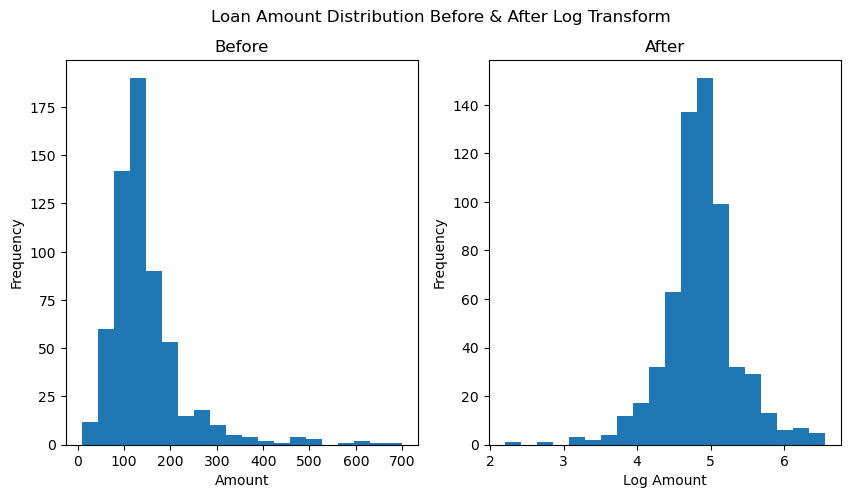

In [16]:
loan = df['LoanAmount']
log_loan = np.log(df['LoanAmount'])

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

fig.suptitle('Loan Amount Distribution Before & After Log Transform')

ax[0].hist(loan, bins=20)
ax[0].set_title('Before')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Amount')

ax[1].hist(log_loan, bins=20)
ax[1].set_title('After')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Log Amount')

plt.show()

In [17]:
df['LoanAmount'] = np.log(df['LoanAmount'])

Combine both incomes as total income and take a log transformation of the same.

In [18]:
df['TotalIncome'] = np.log(df['ApplicantIncome'] + df['CoapplicantIncome'])
df.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)


In [19]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,LP001002,Male,No,0,Graduate,No,4.852030,360.0,1.0,Urban,Y,8.674026
1,LP001003,Male,Yes,1,Graduate,No,4.852030,360.0,1.0,Rural,N,8.714568
2,LP001005,Male,Yes,0,Graduate,Yes,4.189655,360.0,1.0,Urban,Y,8.006368
3,LP001006,Male,Yes,0,Not Graduate,No,4.787492,360.0,1.0,Urban,Y,8.505323
4,LP001008,Male,No,0,Graduate,No,4.948760,360.0,1.0,Urban,Y,8.699515


## 4. Building a Predictive Model

In [20]:
# Reset df to simulate untouched data through pipeline
df = pd.read_csv('../data/data.csv')

In [21]:
# Feature engineering
# Ordinal feature engineering
ordinal_eng = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[['0', '1', '2', '3+']]))
])
# Categorical feature engineering
categoric_eng = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(categories='auto', drop='if_binary'))
])
numeric_features = [
    'ApplicantIncome',
    'CoapplicantIncome',
    'LoanAmount',
    'Loan_Amount_Term',
    'Credit_History'
]
def get_total_income(df):
    df['TotalIncome'] = np.log(df['ApplicantIncome'].astype('float') + df['CoapplicantIncome'].astype('float'))
    df.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)
    return df
def log_loan_amount(df):
    df['LoanAmount'] = np.log(df['LoanAmount'].astype('float'))
    df.drop(columns=['LoanAmount'], inplace=True)
    return df
ordinal_features = [
    'Dependents'
]
one_hot_features = [
    'Gender',
    'Married',
    'Education',
    'Self_Employed',
    'Property_Area'
]
feature_engineering = ColumnTransformer([
    ('numeric_imputer', SimpleImputer(strategy='median'),
     numeric_features),
    ('log_total_income', FunctionTransformer(get_total_income, validate=False),
     ['ApplicantIncome', 'CoapplicantIncome']),
    ('log_loan_amount', FunctionTransformer(log_loan_amount, validate=False),
     ['LoanAmount']),
    ('ordinal_imp_enc', ordinal_eng,
     ordinal_features),
    ('categoric_imp_enc', categoric_eng,
     one_hot_features)
])

In [22]:
# Modeling
log_reg = LogisticRegression(max_iter=100000, tol=1e-6, n_jobs=-1)

pipe = Pipeline([
    ('feature_engineering', feature_engineering),
    ('scaling', StandardScaler()),
    ('log_reg', log_reg)
])

In [23]:
# Necessary step outside of pipeline for train/validation/test
# 1 is Y, 0 is N
loan_status_encoder = LabelBinarizer()
df['Loan_Status'] = loan_status_encoder.fit_transform(df['Loan_Status'])

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Loan_ID', 'Loan_Status']), df['Loan_Status'])


Try paramater grid search to improve the results

In [24]:
param_grid = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
    'log_reg__C': [0.01, 0.03, 0.05, 0.07, 0.09],
    'log_reg__l1_ratio': [0.1, 0.5, 0.9],
}
grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/skle

{'log_reg__C': 0.03, 'log_reg__l1_ratio': 0.1, 'log_reg__penalty': 'l2'}

In [25]:
grid_search.best_score_

0.8043478260869567

Grid search cross validation points to L2 regularization with a C of 0.03 as the best set of hyperparameters for Logistic Regression.

In [26]:
best_log_reg = LogisticRegression(penalty='l2', C=0.03, max_iter=100000, tol=1e-6, n_jobs=-1)
final_pipe = Pipeline([
    ('feature_engineering', feature_engineering),
    ('scaling', StandardScaler()),
    ('log_reg', best_log_reg)
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.8065217391304348

In [27]:
pipe.score(X_test, y_test)

0.8246753246753247

Test score is 2% off of cross validation score, and training score differs a further 1%. Approximation error is low, so the model is doing well.

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [28]:
pickle.dump( pipe, open( "model.p", "wb" ) )

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

In [29]:
URL = "http://ec2-18-116-60-101.us-east-2.compute.amazonaws.com:5555/scoring"
# sending get request and saving the response as response object 

json_data = {
    'Gender': 'Male',
    'Married': 'Yes',
    'Dependents': '3+',
    'Education': 'Graduate',
    'Self_Employed': 'No',
    'ApplicantIncome': 10000,
    'CoapplicantIncome': 10000,
    'LoanAmount': 200,
    'Loan_Amount_Term': 360,
    'Credit_History': 1.0,
    'Property_Area': 'Urban'
}
r = requests.post(url = URL, json = json_data) 

In [30]:
print(r.json())

[[0.25551521369446173, 0.7444847863055383]]
